# Comparison of FFDI using different drought factors

The Griffiths drought factor (DF) is relatively painful to calculate. It is defined by an empirical equation that depends on the soil moisture deficit (SMD) and statistics of any significant rainfall events in the last 20-days. SMD is often estimated using the Keetch-Byram Drought Index (KBDI), which is defined from a simple daily water balance between SMD, effective precipitation (accounting for run-off and interception) and evapotransiration (which is estimated via an empirical equation using the previous day's SMD, maximum temperature and mean annual rainfall).

Richardson et al. (2021) and Squire et al (2021) use a simplified version of the drought factor, defined as the 20-day accumulated rainfall scaled to lie between 0 and 10, with larger values indicating less precipitation. Hereafter we refer to this as the Richardson DF.

In this project assessing CAFE-f6 I'm currently using the Richardson DF to calculate FFDI. This notebook develops some fuctions for computing the KBDI and Griffiths DF, and compares the FFDI computed using the Richardson DF with that computed using the Griffiths DF.

In [2]:
import numpy as np

import xarray as xr

from src import utils
from src.prepare_data import _open

import matplotlib.pyplot as plt

In [3]:
%load_ext lab_black

In [7]:
DATA_PATH = (
    "/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/data/exploratory/"
)

## Cluster

In [9]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: /proxy/8787/status


## Develop functions on some AGCD data

In [8]:
%%time

compute = False

if compute:
    agcd = _open.AGCD(["precip", "tmax"], None, None)

    agcd[["precip"]].sel(time=slice("1960", None)).chunk({"time": -1}).to_zarr(f"{DATA_PATH}/agcd_precip.zarr", mode="w")

    agcd[["tmax"]].sel(time=slice("1960", None)).chunk({"time": -1}).to_zarr(f"{DATA_PATH}/agcd_tmax.zarr", mode="w")

agcd = xr.open_zarr(f"{DATA_PATH}/agcd_precip.zarr", use_cftime=True)
agcd["tmax"] = xr.open_zarr(f"{DATA_PATH}/agcd_tmax.zarr", use_cftime=True)["tmax"]

CPU times: user 753 ms, sys: 16 ms, total: 769 ms
Wall time: 1.06 s


### Calculate KBDI

I originally tried to write this function to use `map_blocks` with `xr.apply_func(..., dask="allowed")`. The difficulty is that `map_blocks` can handle only one output, but I need to pass on between blocks both the current KBDI and the remaining rainfall to be assigned to runoff. There is a hack to allow multiple outputs from `map_blocks`, but this still assumes that the outputs have the same shape, which `KBDI` and `remaining_runoff` do not. The code runs, but it broadcasts `remaining_runoff` across all times in a block, which isn't great - see https://github.com/dougiesquire/Squire_2022_CAFE-f6/blob/1d95b53349e6d3b06f858a746de0a4339c4b979c/notebooks/exploratory/calculate_KBDI.ipynb. I also implemented an approach with `dask.gufunc.apply_gufunc`. Again, this approach relied on a few hacks to get working - see https://github.com/dougiesquire/Squire_2022_CAFE-f6/blob/1c3743d99d564a031710d03bfffe8995b3cde3f4/notebooks/exploratory/calculate_KBDI.ipynb.

For now, let's just use the `dask="parallelized"` solution below and aim to return to this problem at a later date.

In [10]:
from numba import jit
import dask.array as dsa


def calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day=False):
    """
    Calculate the Keetch-Byram drought index, defined as:

        KBDI_n = KBDI_n-1 − Peff + ET

    Peff is the previous 24-hour rainfall amount, precip_n, decreased by an amount to allow
    for interception and/or runoff:

        Peff = precip_n - (interception/runoff)

    where the interception and/or runoff is approximated as the first 5 mm within consecutive
    days with nonzero rainfall.

    ET is the evapotransporation, estimated as:

        ET = (203.2 - KBDI_n-1) * (0.968 * exp(0.0875 * tmax_n-1 + 1.5552) - 8.3)
             -------------------------------------------------------------------- * 10 ** (-3)
                          1 + 10.88 * exp(-0.00173 * precip_annual)

    where tmax_n-1 is the previous day's max temperature and precip_annual is the mean annual
    rainfall.

    Parameters
    ----------
    precip : numpy array with shape [..., N]
        Array of daily precipitation with the last axes corresponding to the time dimension
    tmax : numpy array with shape [..., N]
        Array of max daily temperature with the last axes corresponding to the time dimension
    precip_annual : numpy array with shape [...]
        Array containing the mean annual rainfall. Usually this is computed as the average over
        a period of years corresponding the calculation period of the KBDI
    use_precip_from_previous_day : boolean, optional
        If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
        KBDI_n. See Notes below.

    Notes
    -----
    Daily values represent different things in different datasets. For example:
      - the daily precipitation values in AGCD represent the previous 24-hour rainfall at 9am
        and the daily tmax/tmin values represent the max/min temperatures over the subsequent
        24-hours from 9am. Thus it is appropriate to use precip_n and t_max_n-1 as above in
        order to calculate KBDI_n from the previous 24-hour rainfaill and previous day's max
        temperature.
      - both the daily precipitation and daily max temperature values are assigned to 12pm on
        a given day in CAFE and correspond to the 24-hour period centred on that time. Thus,
        one could argue that it is appropriate to use precip_n-1 and t_max_n-1 (or precip_n
        and tmax_n) to calculate KBDI_n.
      - Daily reanalysis data (e.g. JRA55) is otfen referenced against the inital forecast
        time and the precip and tmax values correspond to the 24-hour period subsequent to the
        reference time. Thus, it is appropriate to use precip_n-1 and tmax_n-1 to calculate
        KBDI_n.

    References
    ----------
    Finkele et al. 2006 (on calculation):
        https://webarchive.nla.gov.au/awa/20060903105143/http://www.bom.gov.au/bmrc/pubs/researchreports/RR119.pdf
    Holgate et al. 2017 (on calculation):
        https://www.publish.csiro.au/wf/WF16217
    Dolling et al. 2005 (on initialisation):
        https://www.sciencedirect.com/science/article/pii/S0168192305001802#bib5
    """

    @jit(nopython=True)
    def _calculate_KBDI(precip, tmax, precip_annual, use_precip_from_previous_day):
        """
        Workhorse function to calculate the KBDI

        Parameters
        ----------
        precip : numpy array with shape [..., N]
            Array of daily precipitation with the last axes corresponding to the time dimension
        tmax : numpy array with shape [..., N]
            Array of max daily temperature with the last axes corresponding to the time dimension
        precip_annual : numpy array with shape [...]
            Array containing the mean annual rainfall. Usually this is computed as the average over
            a period of years corresponding the calculation period of the KBDI
        use_precip_from_previous_day : boolean, optional
            If True, use precip_n-1 to calculate KBDI_n. If False (default) use precip_n to calculate
            KBDI_n.

        Note, I tried writing a version of this function using dask='allowed', rather than
        dask='parallelized', which is generally a better approach. However, the code relied on hacks
        to use apply_gufunc or map_blocks, so I opted for this simpler approach instead. See
        https://github.com/dougiesquire/Squire_2022_CAFE-f6/blob/1c3743d99d564a031710d03bfffe8995b3cde3f4/
            notebooks/exploratory/calculate_KBDI.ipynb
        """

        def calculate_Peff(precip, remaining_runoff):
            """
            Return Peff term in the KBDI and the remaining runoff from the daily
            rainfall
            """
            remaining_runoff = np.where(precip > 0, remaining_runoff, 5.0)
            runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
            Peff = precip - runoff
            return Peff, remaining_runoff - runoff

        def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
            """
            Return evapotransporation (ET) term in the KBDI
            """
            term_1 = 203.2 - KBDI_prev
            term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
            term_3 = 1 + 10.88 * np.exp(-0.00173 * precip_annual)
            return 1e-3 * term_1 * term_2 / term_3

        KBDI = np.zeros_like(precip)

        remaining_runoff = 5.0 * np.ones_like(precip[..., 0])
        if not use_precip_from_previous_day:
            _, remaining_runoff = calculate_Peff(precip[..., 0], remaining_runoff)

        for i in range(1, KBDI.shape[-1]):
            precip_curr = (
                precip[..., i - 1] if use_precip_from_previous_day else precip[..., i]
            )
            Peff, remaining_runoff = calculate_Peff(precip_curr, remaining_runoff)
            ET = calculate_ET(KBDI[..., i - 1], tmax[..., i - 1], precip_annual)
            KBDI_curr = KBDI[..., i - 1] - Peff + ET

            # Limit to between 0 and 200 mm
            KBDI_curr = np.where(KBDI_curr < 0, 0, KBDI_curr)
            KBDI[..., i] = np.where(KBDI_curr > 200, 200, KBDI_curr)

        return KBDI

    KBDI = xr.apply_ufunc(
        _calculate_KBDI,
        precip,
        tmax,
        precip_annual,
        use_precip_from_previous_day,
        input_core_dims=[["time"], ["time"], [], []],
        output_core_dims=[["time"]],
        dask="parallelized",
        output_dtypes=[precip.dtype],
    )

    KBDI = KBDI.rename("KBDI")
    KBDI.attrs["long_name"] = "Keetch-Byram Drought Index (KBDI)"
    KBDI.attrs["standard_name"] = "Keetch-Byram Drought Index"

    return KBDI

In [12]:
%%time

compute = True

if compute:
    calculate_KBDI(
        agcd["precip"],
        agcd["tmax"],
        agcd["precip"].resample(time="A").sum().mean("time"),
    ).to_dataset().to_zarr(f"{DATA_PATH}/agcd_KBDI.zarr", mode="w")

agcd["KBDI"] = xr.open_zarr(f"{DATA_PATH}/agcd_KBDI.zarr", use_cftime=True)["KBDI"]

CPU times: user 2min 23s, sys: 6.76 s, total: 2min 30s
Wall time: 14min 17s


### Check the output by comparing to results in Holgate et al. 2017

In [8]:
Holgate_locations = [
    {"lon": 146.4, "lat": -34.6},
    {"lon": 148.2, "lat": -32.7},
    {"lon": 145.2, "lat": -36.9},
    {"lon": 133.6, "lat": -22.5},
    {"lon": 132.4, "lat": -14.5},
    {"lon": 148.2, "lat": -23.6},
    {"lon": 146.3, "lat": -20.0},
]  # Locations chosen to match Holgate et al. 2017
Holgate_period = slice("2010", "2014")

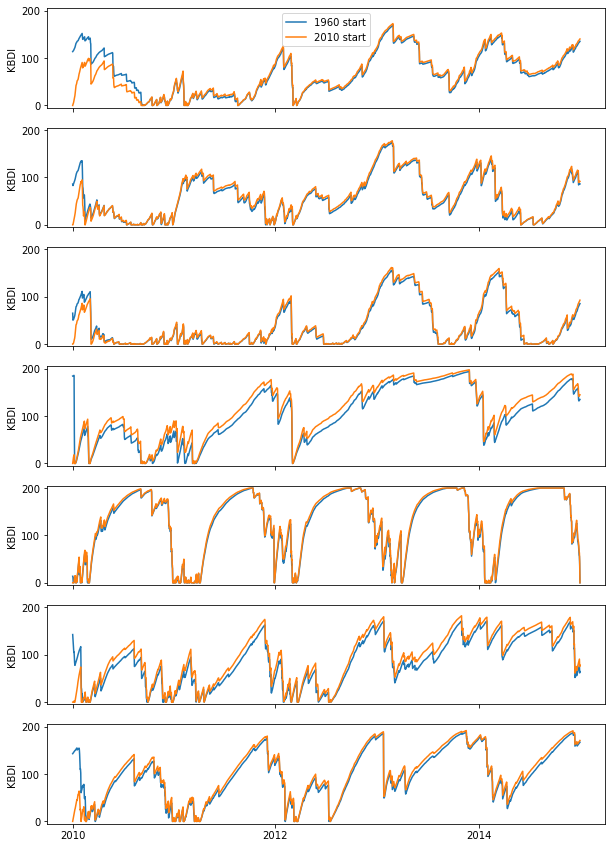

In [9]:
KBDI_start_2010 = calculate_KBDI(
    agcd["precip"].sel(time=Holgate_period),
    agcd["tmax"].sel(time=Holgate_period),
    agcd["precip"].sel(time=Holgate_period).resample(time="A").sum().mean("time"),
)

fig, axs = plt.subplots(len(Holgate_locations), 1, sharex=True, figsize=(10, 15))
for ax, loc in zip(axs, Holgate_locations):
    agcd["KBDI"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="1960 start"
    )
    KBDI_start_2010.sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="2010 start"
    )
    ax.set_ylim(-5, 205)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("KBDI")

_ = axs[0].legend()

### Calculate Drought factor
The vectorized approach arrived at below is obviously very memory hungry. I had to add in automatic chunking along the time dimension after constructing the rolling object to get it to work with large datasets (like AGCD). Note that during this process I also tried:
 - using `xr.apply_ufunc(..., vectorize=True)` with a `calculate_x` function that operates on vectors - this was prohibitively slow
 - using `xr.apply_ufunc(..., dask="allowed")` and wrapping the (unvectorized) `calculate_x` function with numba `guvectorize` - this failed with an uninterpretable serialization error
 - using `xr.apply_ufunc(..., dask="allowed")` and mapping the (unvectorized) `calculate_x` function through `dask.gufunc.apply_gufunc` with `vectorize=True` - this was also prohibitely slow
 - using `xr.apply_ufunc(..., dask="allowed")` and mapping the (unvectorized) `calculate_x` function through `apply_along_axis` - this was also prohibitively slow

In [10]:
def calculate_drought_factor(SMD, precip, limiting_function=None, auto_rechunk=True):
    """
    Calculate the Griffiths (1998) drought factor based on the soil moisture deficit:

        DF = 10.5 * (1 - exp(-(SMD + 30) / 40)) *  41 x**2 + x
                                                 ---------------
                                                 40*x**2 + x + 1

    Parameters
    ----------
    SMD : xarray DataArray
        Values of the daily soil moisture deficit (often KBDI)
    precip : xarray DataArray
        Values of daily precipitation.
    limiting_function : str, optional
        The approach to use to limit the values of the drought factor. Options are:
        - None; x is estimated from the rainfall over the previous 20 days and the time
          since it fell:
                      N**1.3
                  --------------    if N >= 1 & P > 2mm
                  N**1.3 + P - 2
              x =     0.8**1.3
                  ----------------  if N = 0  & P > 2mm
                  0.8**1.3 + P - 2
                         1          if P < 2mm
          see Finkele et al. 2006 for details on how P and N are estimated from daily rainfall
        - 'xlim'; x is estimated as above and limited to:
                            1
                     ----------------       if SMD < 20
                     1 + 0.1135 * SMD
              xlim =        75
                     ---------------------  if SMD >= 20
                     270.525 - 1.267 * SMD
        - 'discrete'; x is estimated as above but the resulting drought factor is limited to the
          following values:
                   6   if 0   <  SMD < 25
                   7   if 25  <= SMD < 42
              DF = 8   if 42  <= SMD < 65
                   9   if 65  <= SMD < 100
                   10  if 100 <= SMD <= 200
    auto_rechunk : boolean, optional
        If True, automatically rechunk precip for better memory management. Note that this will
        mean the output will be chunked differently than the inputs.
    """

    def _calculate_x(precip_windows):
        """
        Return the minimum value of the x function for a given preciptation window

        This function is vectorized and very memory hungry
        """

        def _x_function(P, N):
            """
            Calculate x from the accumulated rainfall within an event and the number
            of days N since the large daily rainfall in that event
            """
            x = (N**1.3) / (N**1.3 + P - 2.0)
            x = np.where(N == 0.0, (0.8**1.3) / (0.8**1.3 + P - 2.0), x)
            x = np.where(P <= 2.0, 1.0, x)
            return x

        # Label events (consecutive elements with P > 2) along the window axis
        events = precip_windows > 2.0
        event_cumsum = np.cumsum(events, axis=-1, dtype=np.int32)[..., 1:]
        shifted_event_cumsum = np.cumsum(
            np.where(events[..., :-1], events[..., 1:], False), axis=-1, dtype=np.int32
        )
        labelled_events = np.where(
            events[..., 1:], event_cumsum - shifted_event_cumsum, 0
        )

        # Loop over all events and compute the minimum x
        if isinstance(precip_windows, dsa.Array):
            # 10 is the max number of events in a 20-day period. Calculating the actual
            # max number of events will trigger computation
            max_events = 10
        else:
            max_events = np.max(labelled_events)
        for label in range(1, max_events + 1):
            P = np.sum(
                np.where(labelled_events == label, precip_windows[..., 1:], 0), axis=-1
            )
            N = 20 - np.argmax(
                np.where(labelled_events == label, precip_windows[..., 1:], 0), axis=-1
            )
            if label == 1:
                x = _x_function(P, N)
            else:
                x = np.minimum(x, _x_function(P, N))

        return x

    def _calculate_DF(SMD, x):
        """Calculate the drought factor using the Griffiths formula"""
        term_1 = 10.5 * (1 - np.exp(-(SMD + 30) / 40))
        term_2 = 41 * x**2 + x
        term_3 = 40 * x**2 + x + 1
        return term_1 * term_2 / term_3

    def _apply_limits(x, limits):
        """
        Apply limit on x, where limits is a list of conditions and corresponding
        limits, e.g. [(condition_1, limit_1), (condition_2, limit_2)...]
        """
        for condition, limit in limits:
            x = xr.where(condition & (x > limit), limit, x)
        return x

    def _apply_xlim(x, SMD):
        """Limit x using the 'xlim' function"""
        cond_1 = (SMD < 20, 1 / (1 + 0.1135 * SMD))
        cond_2 = (SMD >= 20, 75 / (270.525 - 1.267 * SMD))
        return _apply_limits(x, [cond_1, cond_2])

    def _apply_discrete(DF, SMD):
        """Limit DF using the 'discrete' function"""
        cond_1 = ((SMD > 0) & (SMD < 25), 6)
        cond_2 = ((SMD >= 25) & (SMD < 42), 7)
        cond_3 = ((SMD >= 42) & (SMD < 65), 8)
        cond_4 = ((SMD >= 65) & (SMD < 100), 9)
        cond_5 = ((SMD >= 100) & (SMD <= 200), 10)
        return _apply_limits(DF, [cond_1, cond_2, cond_3, cond_4, cond_5])

    # Use a window size of 21 as the first element is dropped in the calculation of x
    precip_rolling = precip.rolling(time=21).construct(window_dim="window")

    # Adjust chunk size otherwise chunks are enormous
    if isinstance(precip_rolling.data, dsa.Array) & auto_rechunk:
        precip_rolling = precip_rolling.chunk({"time": "auto"})

    x = xr.apply_ufunc(
        _calculate_x,
        precip_rolling,
        input_core_dims=[["window"]],
        dask="allowed",
    )

    if limiting_function is None:
        DF = _calculate_DF(SMD, x)
    elif limiting_function == "xlim":
        DF = _calculate_DF(SMD, _apply_xlim(x, SMD))
    elif limiting_function == "discrete":
        DF = _apply_discrete(_calculate_DF(SMD, x), SMD)

    DF = DF.rename("DF")
    DF.attrs["long_name"] = "Griffiths Drought Factor (DF)"
    DF.attrs["standard_name"] = "drought_factor"
    DF.attrs["units"] = "-"

    return DF

### Check limiting functions

In [11]:
KBDI_test = agcd["KBDI"].sel(Holgate_locations[0])
precip_test = agcd["precip"].sel(Holgate_locations[0])

KBDI_nolim = calculate_drought_factor(KBDI_test, precip=precip_test)
KBDI_xlim = calculate_drought_factor(
    KBDI_test, precip=precip_test, limiting_function="xlim"
)
KBDI_discrete = calculate_drought_factor(
    KBDI_test, precip=precip_test, limiting_function="discrete"
)

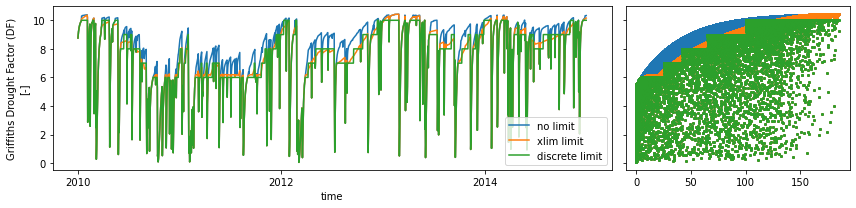

In [12]:
fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    figsize=(12, 3),
    gridspec_kw={"width_ratios": [3, 1.2]},
)

KBDI_nolim.sel(time=slice("2010", "2014")).plot(ax=axs[0], label="no limit")
KBDI_xlim.sel(time=slice("2010", "2014")).plot(ax=axs[0], label="xlim limit")
KBDI_discrete.sel(time=slice("2010", "2014")).plot(ax=axs[0], label="discrete limit")

axs[1].plot(KBDI_test, KBDI_nolim, "o", markersize=2)
axs[1].plot(KBDI_test, KBDI_xlim, "o", markersize=2)
axs[1].plot(KBDI_test, KBDI_discrete, "o", markersize=2)

axs[0].legend()
axs[0].set_title("")

plt.tight_layout()

### How does this run on the full dataset?

In [13]:
%%time

compute = False

if compute:
    calculate_drought_factor(
        agcd["KBDI"],
        agcd["precip"],
        limiting_function="xlim",
    ).to_dataset().to_zarr(f"{DATA_PATH}/agcd_DF.zarr", mode="w")

agcd["DF"] = xr.open_zarr(f"{DATA_PATH}/agcd_DF.zarr", use_cftime=True)["DF"]

CPU times: user 454 ms, sys: 57.9 ms, total: 512 ms
Wall time: 588 ms


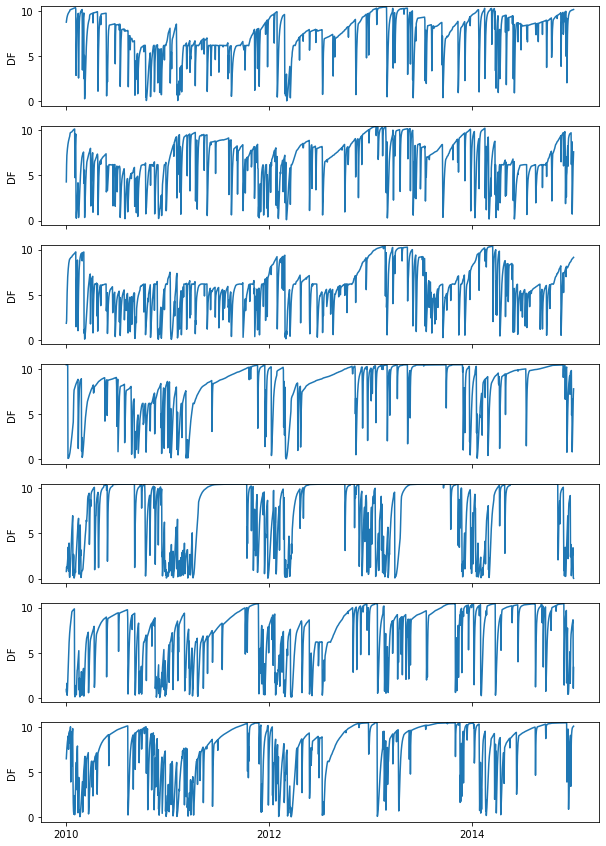

In [14]:
fig, axs = plt.subplots(len(Holgate_locations), 1, sharex=True, figsize=(10, 15))
for ax, loc in zip(axs, Holgate_locations):
    agcd["DF"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(ax=ax)

    ax.set_ylim(-0.5, 10.5)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("DF")

## How does the Richardson formulation of FFDI compare to the standard definition?
The Richardson formulation uses the Richardson DF and the standard formulation uses the Griffiths DF. We'll use JRA55 data to make the comparison.

In [15]:
jra55 = _open.JRA55(
    ["TPRAT_GDS0_SFC", "TMAX_GDS4_HTGL", "RH_GDS0_HTGL", "WSMX_GDS4_HTGL"],
    "surface_daily",
    None,
)

jra55 = utils.rename(
    jra55,
    TPRAT_GDS0_SFC="precip",
    TMAX_GDS4_HTGL="t_ref_max",
    RH_GDS0_HTGL="rh",
    WSMX_GDS4_HTGL="V_tot",
    initial_time0_hours="time",
    g0_lat_1="lat",
    g0_lat_2="lat",
    g0_lon_2="lon",
    g0_lon_3="lon",
)

jra55 = utils.convert(jra55, t_ref_max={"add": -273.15}, V_tot={"multiply_by": 3.6})

jra55 = jra55.chunk({"time": -1, "lat": 19, "lon": 32})

### Calculate KBDI

In [16]:
%%time

compute = False

if compute:
    calculate_KBDI(
        jra55["precip"],
        jra55["t_ref_max"],
        jra55["precip"].resample(time="A").sum().mean("time"),
        use_precip_from_previous_day=True,
    ).to_dataset().to_zarr(f"{DATA_PATH}/jra55_KBDI.zarr", mode="w")

jra55["KBDI"] = xr.open_zarr(f"{DATA_PATH}/jra55_KBDI.zarr", use_cftime=True)["KBDI"]

CPU times: user 634 ms, sys: 7.22 ms, total: 641 ms
Wall time: 693 ms


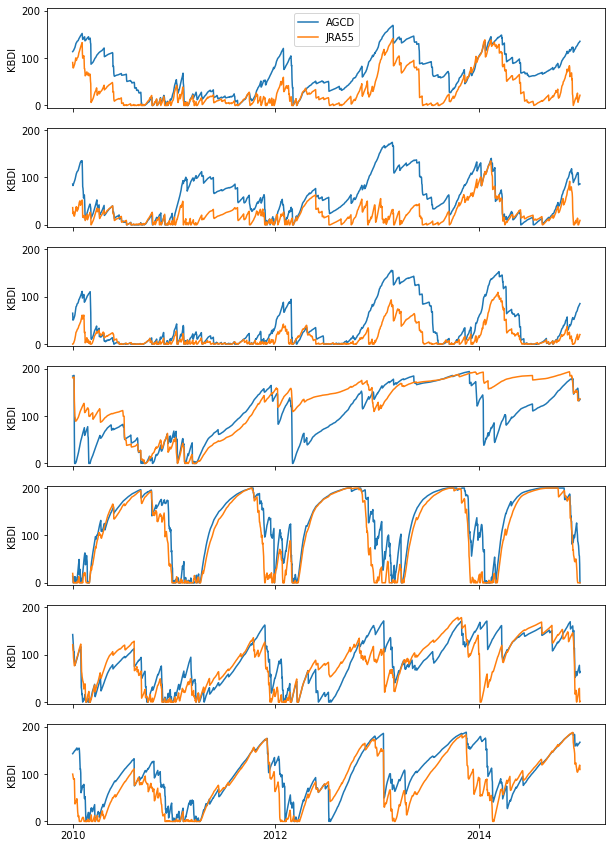

In [19]:
fig, axs = plt.subplots(len(Holgate_locations), 1, sharex=True, figsize=(10, 15))
for ax, loc in zip(axs, Holgate_locations):
    agcd["KBDI"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="AGCD"
    )
    jra55["KBDI"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="JRA55"
    )
    ax.set_ylim(-5, 205)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("KBDI")

_ = axs[0].legend()

### Calculate Drought Factor

In [21]:
%%time

compute = False

if compute:
    calculate_drought_factor(
        jra55["KBDI"],
        jra55["precip"],
        limiting_function="xlim",
    ).to_dataset().to_zarr(f"{DATA_PATH}/jra55_DF.zarr", mode="w")

jra55["DF"] = xr.open_zarr(f"{DATA_PATH}/jra55_DF.zarr", use_cftime=True)["DF"]

CPU times: user 644 ms, sys: 3.5 ms, total: 647 ms
Wall time: 740 ms


In [22]:
%%time

compute = False

if compute:
    p20 = jra55["precip"].rolling({"time": 20}).sum()
    jra55_RDF = (
        -10 * (p20 - p20.min("time")) / (p20.max("time") - p20.min("time")) + 10
    ).to_dataset(name="RDF")

    jra55_RDF.to_zarr(f"{DATA_PATH}/jra55_RDF.zarr", mode="w")

jra55["RDF"] = xr.open_zarr(f"{DATA_PATH}/jra55_RDF.zarr", use_cftime=True)["RDF"]

CPU times: user 949 ms, sys: 120 ms, total: 1.07 s
Wall time: 1.12 s


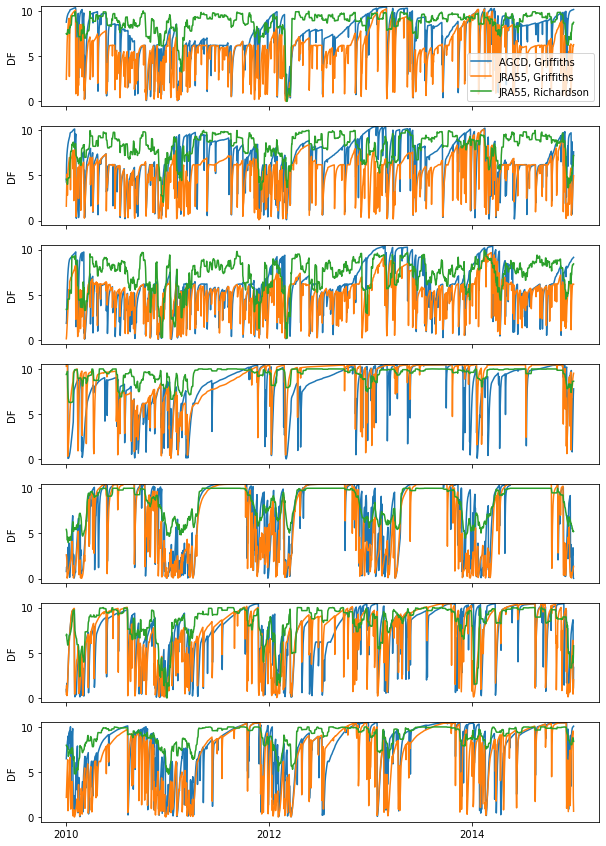

In [23]:
fig, axs = plt.subplots(len(Holgate_locations), 1, sharex=True, figsize=(10, 15))
for ax, loc in zip(axs, Holgate_locations):
    agcd["DF"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="AGCD, Griffiths"
    )
    jra55["DF"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="JRA55, Griffiths"
    )
    jra55["RDF"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="JRA55, Richardson"
    )
    ax.set_ylim(-0.5, 10.5)
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("DF")

_ = axs[0].legend()

### Calculate FFDI

In [24]:
def calculate_FFDI(
    drought_factor,
    t_max,
    rh,
    wind_max,
):
    """
    Returns the McArthur Forest Fire Danger Index as follows:

        FFDI = D ** 0.987 * exp (0.0338 * T - 0.0345 * H + 0.0234 * W + 0.243147)

    Parameters
    ----------
    drought_factor : xarray DataArray
        The drought factor to be used as D in the above equation.
    t_max : xarray DataArray
        The max daily temperature or similar [deg C] to be used as T in the above
        equation.
    rh : xarray DataArray
        The daily max relative humidity at 2m or similar [%] to be used as H in the
        above equation.
    wind_max : xarray DataArray
        The daily max 10 m wind speed or similar [km/h] to be used as W in the above
        equation.

    References
    ----------
    Dowdy, A. J. (2018). “Climatological Variability of Fire Weather in Australia”.
    Journal of Applied Meteorology and Climatology 57.2, pp. 221–234. issn:
    1558-8424. doi: 10.1175/JAMC-D-17-0167.1.
    """

    FFDI = drought_factor**0.987 * np.exp(
        0.0338 * t_max - 0.0345 * rh + 0.0234 * wind_max + 0.243147
    )

    FFDI = FFDI.rename("FFDI")
    FFDI.attrs["long_name"] = "McArthur Forest Fire Danger Index"
    FFDI.attrs["standard_name"] = "FFDI"
    FFDI.attrs["units"] = "-"

    return FFDI

In [25]:
%%time

compute = False

if compute:
    calculate_FFDI(
        jra55["DF"], jra55["t_ref_max"], jra55["rh"], jra55["V_tot"]
    ).to_dataset().to_zarr(f"{DATA_PATH}/jra55_FFDI_DF.zarr", mode="w")
    calculate_FFDI(
        jra55["RDF"], jra55["t_ref_max"], jra55["rh"], jra55["V_tot"]
    ).to_dataset().to_zarr(f"{DATA_PATH}/jra55_FFDI_RDF.zarr", mode="w")

jra55["FFDI_DF"] = xr.open_zarr(f"{DATA_PATH}/jra55_FFDI_DF.zarr", use_cftime=True)["FFDI"]
jra55["FFDI_RDF"] = xr.open_zarr(f"{DATA_PATH}/jra55_FFDI_RDF.zarr", use_cftime=True)["FFDI"]

CPU times: user 1.29 s, sys: 17 ms, total: 1.31 s
Wall time: 1.43 s


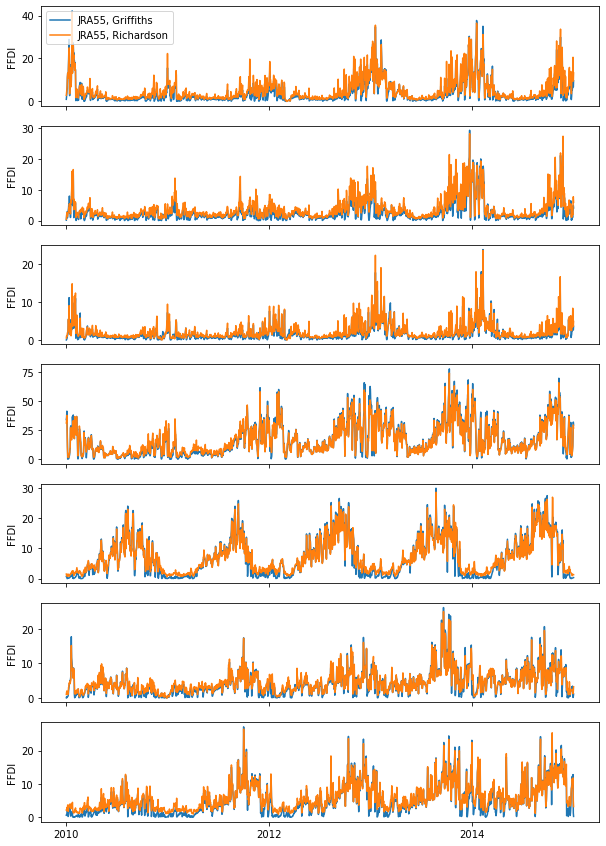

In [26]:
fig, axs = plt.subplots(len(Holgate_locations), 1, sharex=True, figsize=(10, 15))
for ax, loc in zip(axs, Holgate_locations):
    jra55["FFDI_DF"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="JRA55, Griffiths"
    )
    jra55["FFDI_RDF"].sel(loc, method="nearest").sel(time=slice("2010", "2014")).plot(
        ax=ax, label="JRA55, Richardson"
    )
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("FFDI")

_ = axs[0].legend()

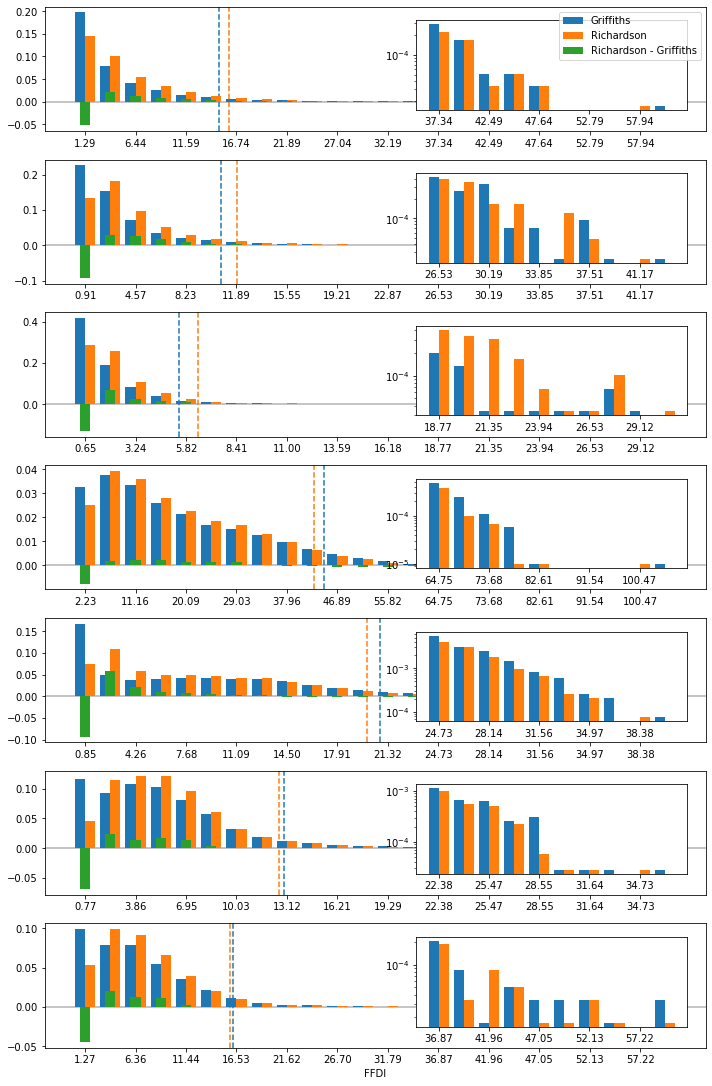

In [27]:
fig, axs = plt.subplots(len(Holgate_locations), 1, figsize=(10, 15))
for ax, loc in zip(axs, Holgate_locations):
    FFDI_DF = jra55["FFDI_DF"].sel(loc, method="nearest").compute()
    FFDI_RDF = jra55["FFDI_RDF"].sel(loc, method="nearest").compute()
    bins = np.linspace(
        min(FFDI_DF.min(), FFDI_RDF.min()), max(FFDI_DF.max(), FFDI_RDF.max()), 25
    )
    bin_width = bins[1] - bins[0]
    bin_centres = (bins[:-1] + bins[1:]) / 2
    FFDI_DF_hist, _ = np.histogram(FFDI_DF, bins=bins, density=True)
    FFDI_RDF_hist, _ = np.histogram(FFDI_RDF, bins=bins, density=True)

    ax.bar(
        bin_centres - bin_width / 5,
        FFDI_DF_hist,
        width=2 * bin_width / 5,
        label="Griffiths",
        color="C0",
    )
    ax.bar(
        bin_centres + bin_width / 5,
        FFDI_RDF_hist,
        width=2 * bin_width / 5,
        label="Richardson",
        color="C1",
    )
    ax.bar(
        bin_centres,
        FFDI_RDF_hist - FFDI_DF_hist,
        width=2 * bin_width / 5,
        label="Richardson - Griffiths",
        color="C2",
    )
    ax.set_xticks(bin_centres[::2])
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], color=[0.7, 0.7, 0.7], zorder=-1)
    ax.set_xlim(xlim)

    FFDI_DF_p = FFDI_DF.quantile(q=0.95, dim="time")
    FFDI_RDF_p = FFDI_RDF.quantile(q=0.95, dim="time")
    ylim = ax.get_ylim()
    ax.plot([FFDI_DF_p, FFDI_DF_p], ylim, linestyle="--", color="C0", zorder=-1)
    ax.plot([FFDI_RDF_p, FFDI_RDF_p], ylim, linestyle="--", color="C1", zorder=-1)
    ax.set_ylim(ylim)

    axin = ax.inset_axes([0.562, 0.17, 0.41, 0.72])
    keep = bin_centres > 0.6 * max(bin_centres)
    axin.bar(
        bin_centres[keep] - bin_width / 5,
        FFDI_DF_hist[keep],
        width=2 * bin_width / 5,
        label="Griffiths",
        color="C0",
    )
    axin.bar(
        bin_centres[keep] + bin_width / 5,
        FFDI_RDF_hist[keep],
        width=2 * bin_width / 5,
        label="Richardson",
        color="C1",
    )
    axin.set_xticks(bin_centres[keep][::2])
    axin.set_yscale("log")

plt.tight_layout()
axs[-1].set_xlabel("FFDI")
_ = axs[0].legend()

So the Richardson DF seems to produce an underestimate of the number of very low FFDI days relative to the Griffith DF. The extreme values, however, appear to be similar.

In [27]:
cluster.close()
client.close()